<a href="https://colab.research.google.com/github/rowanho/Inverted-Index-Generator/blob/master/GAN_with_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

In [2]:
#@title
import math
from time import sleep
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [24]:
#@title
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

training_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
]))

test_data =  torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
]))

bird_plane_horse_positions = [i for i, _ in enumerate(training_data) if training_data.targets[i] in [0, 1, 7]]

bird_plane_horse_test_positions = [i for i, _ in enumerate(test_data) if test_data.targets[i] in [0, 1, 7]]

train_loader = torch.utils.data.DataLoader(
    training_data,
    sampler=torch.utils.data.SubsetRandomSampler(bird_plane_horse_positions), # Only keep birds and horses
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    sampler=torch.utils.data.SubsetRandomSampler(bird_plane_horse_test_positions), # Only keep birds and horses
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

Files already downloaded and verified
Files already downloaded and verified


**Create a classifier for the CIFAR10 data**

In [0]:
#@title
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

** Train the classifier **

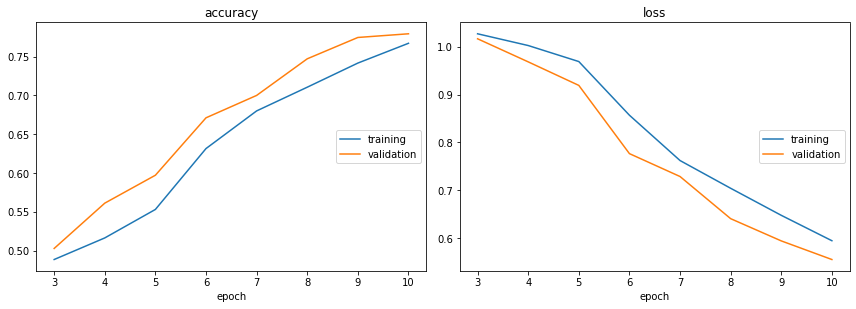

accuracy:
training   (min:    0.318, max:    0.767, cur:    0.767)
validation (min:    0.387, max:    0.780, cur:    0.780)

loss:
training   (min:    0.595, max:    1.627, cur:    0.595)
validation (min:    0.555, max:    1.066, cur:    0.555)


In [26]:
#@title
C = Classifier().to(device)

# initialise the optimiser
optimiser = torch.optim.SGD(C.parameters(), lr=0.001, momentum=0.9)
epoch = 0
no_epochs = 15
liveplot = PlotLosses()
loss_func = nn.CrossEntropyLoss()
# train and test
while (epoch<no_epochs):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_loss_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate over the train dateset
    for (x,t) in train_loader:
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        o = C(x)
        loss = loss_func(o, t).to(device)
        loss.backward()
        optimiser.step()
        pred = o.argmax(dim=1, keepdim=True)

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())
    # iterate entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)

        o = C(x)
        loss = loss_func(o, t).to(device)

        pred = o.argmax(dim=1, keepdim=True)

        test_loss_arr = np.append(test_loss_arr, loss.cpu().data)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    liveplot.update({
        'accuracy': train_acc_arr.mean(),
        'val_accuracy': test_acc_arr.mean(),
        'loss': train_loss_arr.mean(),
        'val_loss': test_loss_arr.mean()
    })    
    liveplot.draw()

    epoch = epoch+1

saved_classifier = C.state_dict()

** Define the generator and discriminator **

In [0]:
#@title
class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            nn.Conv2d(3, f, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(f, f*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(f*2, f*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(f*4, f*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.last_step = nn.Sequential(nn.Conv2d(f*8, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        features = self.discriminate(x)
        res = self.last_step(features)
        return res


class Generator(nn.Module):
    def __init__(self, f=64):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(100, f*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*8, f*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*4, f*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(f*2, f, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f),
            nn.ReLU(True),
            nn.ConvTranspose2d(f, 3, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        return self.generate(z)

    


In [0]:
# Use BCELoss function

# Parameters
lr_g = 0.0002
lr_d = 0.00005

beta1 = 0.5
bce_loss = nn.BCELoss()
epoch = 0
num_epochs = 100
liveplot = PlotLosses()

G = Generator().to(device)
D = Discriminator().to(device)
epoch = 0
liveplot = PlotLosses()
optimiser_G = torch.optim.Adam(G.parameters(), lr=lr_g, betas=(beta1, 0.999))
optimiser_D = torch.optim.Adam(D.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [15]:
# training loop, feel free to also train on the test dataset if you like for generating the pegasus
while (epoch<num_epochs):
    
    # arrays for metrics
    logs = {}
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for (x, t) in train_loader:
        x, t = x.to(device), t.to(device)

        # Generate iamges from noise
        x_n = G.generate(torch.randn(x.size(0), 100, 1, 1).to(device))

        # Discriminate the real and fake images
        d_r = D(x)
        d_n = D(x_n)

        # train discriminator 
        optimiser_D.zero_grad()
        loss_d = bce_loss(d_r, torch.ones(64).to(device)) + \
               bce_loss(d_n, torch.zeros(64).to(device))
        loss_d.backward()
        optimiser_D.step()
        dis_loss_arr = np.append(dis_loss_arr, loss_d.cpu().data)

        # Train generator and encoder
        loss_g = bce_loss(d_n,  torch.ones(64).to(device))

        optimiser_G.zero_grad()
        loss_g.backward()
        optimiser_G.step()
        gen_loss_arr = np.append(gen_loss_arr, loss_g.cpu().data)

    # plot some examples
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(x_n).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    liveplot.update({
        'generator loss': gen_loss_arr.mean(),
        'discriminator loss': dis_loss_arr.mean(),
    })
    liveplot.draw()
    sleep(1.)

    epoch = epoch+1

saved_generator = G.state_dict()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


RuntimeError: ignored